<a href="https://colab.research.google.com/github/RobinMikeal/Geol558/blob/main/Geol558_Proj_2_Supervised_Classification_EDA_Robin_Mikeal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gemstone Classification using Supervised Classification Techniques on Images
Robin Mikeal:  
Geol 558, Project 2, Spring 2025
#Abstract

To be written

#Intro

This project will evaluate the effectiveness of different supervised classification techniques on mineral images.  This is not considered big data.  This is actually a fairly small dataset of about 3000 images curated on Kaggle by Daria Chemkaeva from minerals.net and www.rasavgems.com websites. My goal is to see how effective variations in the data (image size, presence of background, variety of images content such as shape) affects the classification.

#Installs and Imports

Using the kaggle api

In [56]:
!pip install kaggle
!pip install torch
!pip install torchvision

Use high ram runtime, with a T4 GPU

In [57]:
import pandas as pd
import os
import shutil
import zipfile
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib.colors import to_hex


#2.0 Data Loading

This data was attained from Kaggle.

Note, you will need to change to your key and username

In [58]:
os.environ['KAGGLE_USERNAME'] = 'robinmikeal'
os.environ['KAGGLE_KEY'] = '7e4ac2b1741e53bd83956c3d501c4551'

In [59]:
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
kaggle_json = '{"username":"%KAGGLE_USERNAME%","key":"%KAGGLE_KEY%"}'
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write(kaggle_json)
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [60]:
if os.path.exists('gemstones-images'):
    shutil.rmtree('gemstones-images')
!kaggle datasets download -d lsind18/gemstones-images
with zipfile.ZipFile('gemstones-images.zip', 'r') as zip_ref:
    zip_ref.extractall('gemstones-images')


Dataset URL: https://www.kaggle.com/datasets/lsind18/gemstones-images
License(s): other
gemstones-images.zip: Skipping, found more recently modified local copy (use --force to force download)


This dataset was already grouped in Train and Test datasubfolders.  A summary of each subfolder name and the number of images for each subbfolder, and a total sum of images is provided for the test and train data below, but is commented out for brevity.  This has been summarized in a data frame below.

In [61]:
# Define the directory path
directorytest = 'gemstones-images/test'  # Update this path based on your extracted dataset structure

# Initialize a dictionary to store the count of jpg files in each subfolder
subfolder_counts = {}

## Walk through the directory
#for root, dirs, files in os.walk(directorytest):
    #for subfolder in dirs:
        #subfolder_path = os.path.join(root, subfolder)
        #jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        #subfolder_counts[subfolder] = jpg_count

## Print the names of the unique subfolders and the count of jpgs within each
#for subfolder, count in subfolder_counts.items():
    #print(f"Subfolder: {subfolder}, JPG Count: {count}")

## Print the total count of unique subfolders and total number of jpgs
#total_subfolders = len(subfolder_counts)
#total_jpgs = sum(subfolder_counts.values())

#print(f"Test Dataset Summary:")
#print(f"Total unique subfolders: {total_subfolders}")
#print(f"Total number of JPGs: {total_jpgs}")

In [62]:
# Define the directory path
directorytrain = 'gemstones-images/train'  # Update this path based on your extracted dataset structure

# Initialize a dictionary to store the count of jpg files in each subfolder
subfolder_counts = {}

# Walk through the directory
#for root, dirs, files in os.walk(directorytrain):
    #for subfolder in dirs:
        #subfolder_path = os.path.join(root, subfolder)
        #jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        #subfolder_counts[subfolder] = jpg_count

# Print the names of the unique subfolders and the count of jpgs within each
#for subfolder, count in subfolder_counts.items():
    #print(f"Subfolder: {subfolder}, JPG Count: {count}")

## Print the total count of unique subfolders and total number of jpgs
#total_subfolders = len(subfolder_counts)
#total_jpgs = sum(subfolder_counts.values())

#print(f"Train Dataset Summary:")
#print(f"Total unique subfolders: {total_subfolders}")
#print(f"Total number of JPGs: {total_jpgs}")

I created a dataframe of all of the subfolder names and counts of the images in each corresponding folder for both test and train directories in order to calculate a split percentage.

In [63]:
train_counts = {}
for root, dirs, files in os.walk(directorytrain):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        train_counts[subfolder] = jpg_count

test_counts = {}
for root, dirs, files in os.walk(directorytest):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        test_counts[subfolder] = jpg_count


data = []
for mineral in train_counts:
  data.append([mineral, train_counts[mineral], test_counts.get(mineral,0)])

df = pd.DataFrame(data, columns=['Mineral', 'TrainCount', 'TestCount'])

df['TrnTstSplitRatio'] = df['TrainCount']/(df['TrainCount'] + df['TestCount'])

df

,Mineral,TrainCount,TestCount,TrnTstSplitRatio
0,Diamond,31,4,0.885714
1,Amethyst,35,4,0.897436
2,Sapphire Yellow,31,4,0.885714
3,Sapphire Purple,31,4,0.885714
4,Coral,31,4,0.885714
...,...,...,...,...
82,Goshenite,31,4,0.885714
83,Chrysoprase,30,4,0.882353
84,Rhodochrosite,29,4,0.878788
85,Cats Eye,31,4,0.885714


In [64]:
print(df.shape)
df.describe().round(2)

(87, 4)


,TrainCount,TestCount,TrnTstSplitRatio
count,87.00,87.00,87.00
mean,32.83,4.17,0.89
std,3.69,0.38,0.01
min,27.00,4.00,0.87
25%,30.00,4.00,0.88
50%,32.00,4.00,0.89
75%,35.00,4.00,0.89
max,45.00,5.00,0.90


The describe stats are not particularly useful yet.  But it may be used later on again after more features are engineered.

In [65]:
train_sum = df['TrainCount'].sum()
test_sum = df['TestCount'].sum()
avg_ratio = df['TrnTstSplitRatio'].mean()

print(f"Sum of TrainCount: {train_sum}")
print(f"Sum of TestCount: {test_sum}")
print(f"Average of TrnTstSplitRatio: {avg_ratio:.2f}")

Sum of TrainCount: 2856
Sum of TestCount: 363
Average of TrnTstSplitRatio: 0.89


The total number of images is 3,219.  There are 87 unique gemstones in both the test and the train dataset.  Let's display a histogram of all of the counts of jpgs within the unique subfolders of directorytrain to get a sense of the number of images per stone type.

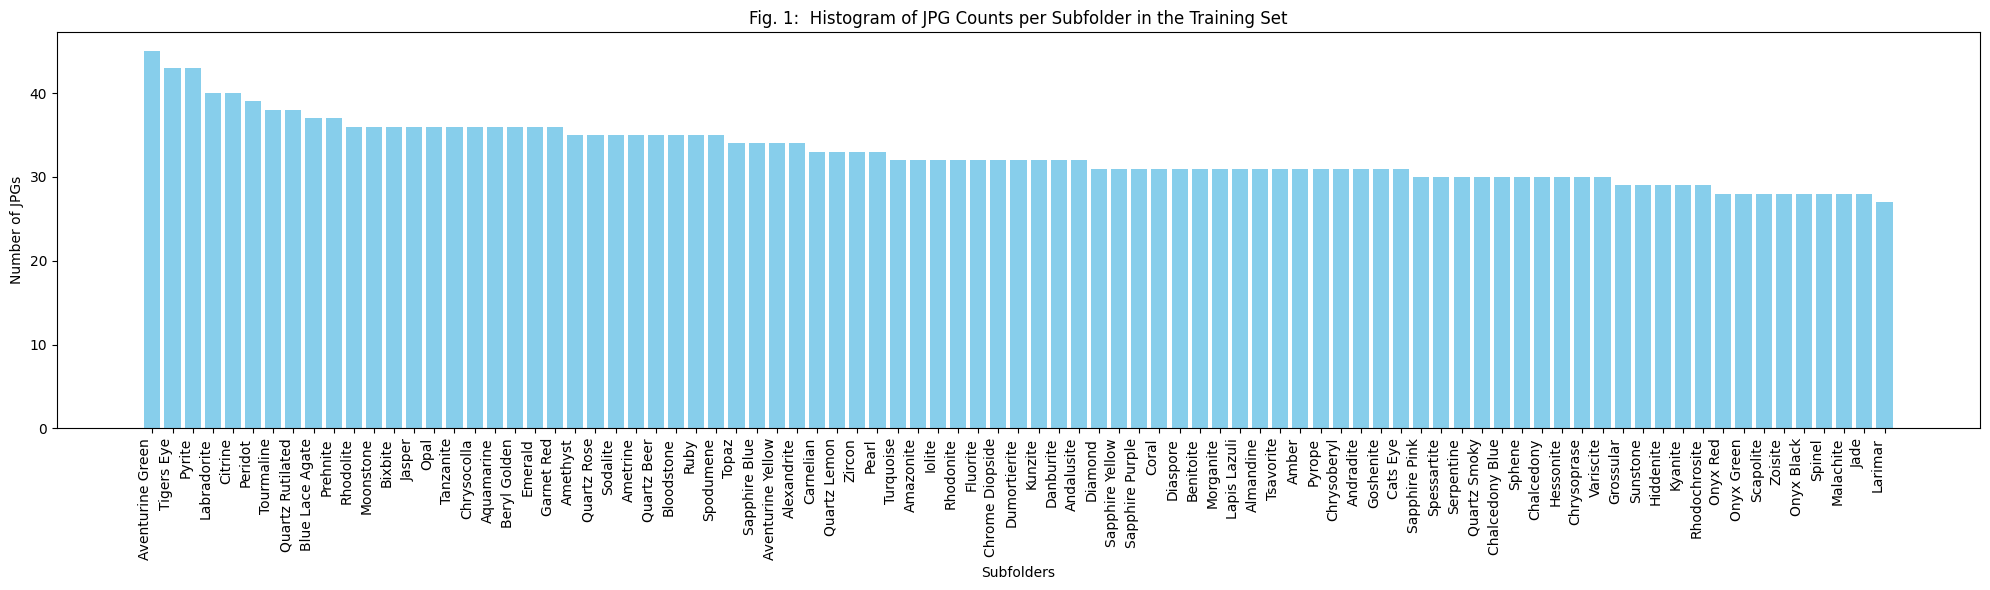

In [66]:
directorytrain = 'gemstones-images/train'
subfolder_counts = {}
for root, dirs, files in os.walk(directorytrain):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        subfolder_counts[subfolder] = jpg_count

# Sort subfolders by image count in descending order
sorted_subfolders = sorted(subfolder_counts, key=subfolder_counts.get, reverse=True)
sorted_counts = [subfolder_counts[subfolder] for subfolder in sorted_subfolders]


# Create the histogram
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.bar(sorted_subfolders, sorted_counts, color='skyblue')
plt.xlabel("Subfolders")
plt.ylabel("Number of JPGs")
plt.title("Fig. 1:  Histogram of JPG Counts per Subfolder in the Training Set")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

Next let's take a sneak peak of some random images from directorytrain with labels just to check to make sure the files look good.

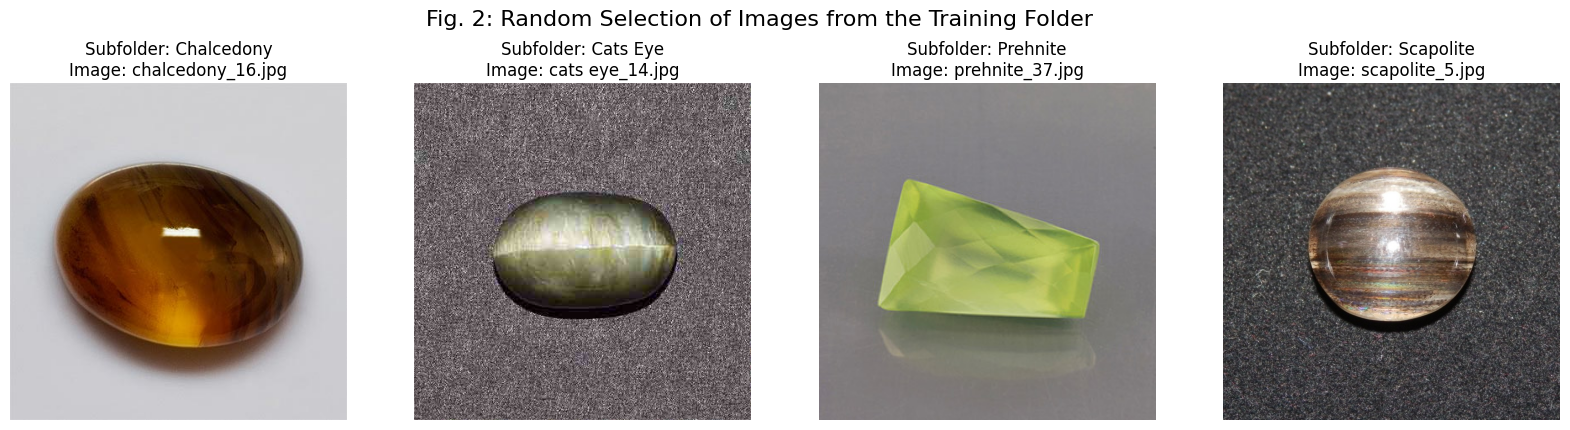

In [67]:
directorytrain = 'gemstones-images/train'

# Get a list of all subfolders in the directory
subfolders = [f.name for f in os.scandir(directorytrain) if f.is_dir()]

# Select 4 random subfolders
selected_subfolders = random.sample(subfolders, min(4, len(subfolders)))

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Fig. 2: Random Selection of Images from the Training Folder', fontsize=16)

# Loop through the selected subfolders and display one random image from each
for i, subfolder in enumerate(selected_subfolders):
    subfolder_path = os.path.join(directorytrain, subfolder)
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image)
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Subfolder: {subfolder}\nImage: {random_image}")
        axes[i].axis('off') # Hide axis ticks and labels
    else:
        axes[i].text(0.5, 0.5, f"No images in {subfolder}", ha='center', va='center')
        axes[i].axis('off')


plt.show()

A pixel correlation matrix was also completed, but it did not reveal any patterns that would be visually helpful.  But it might be interesting to know all those that have the most blue.


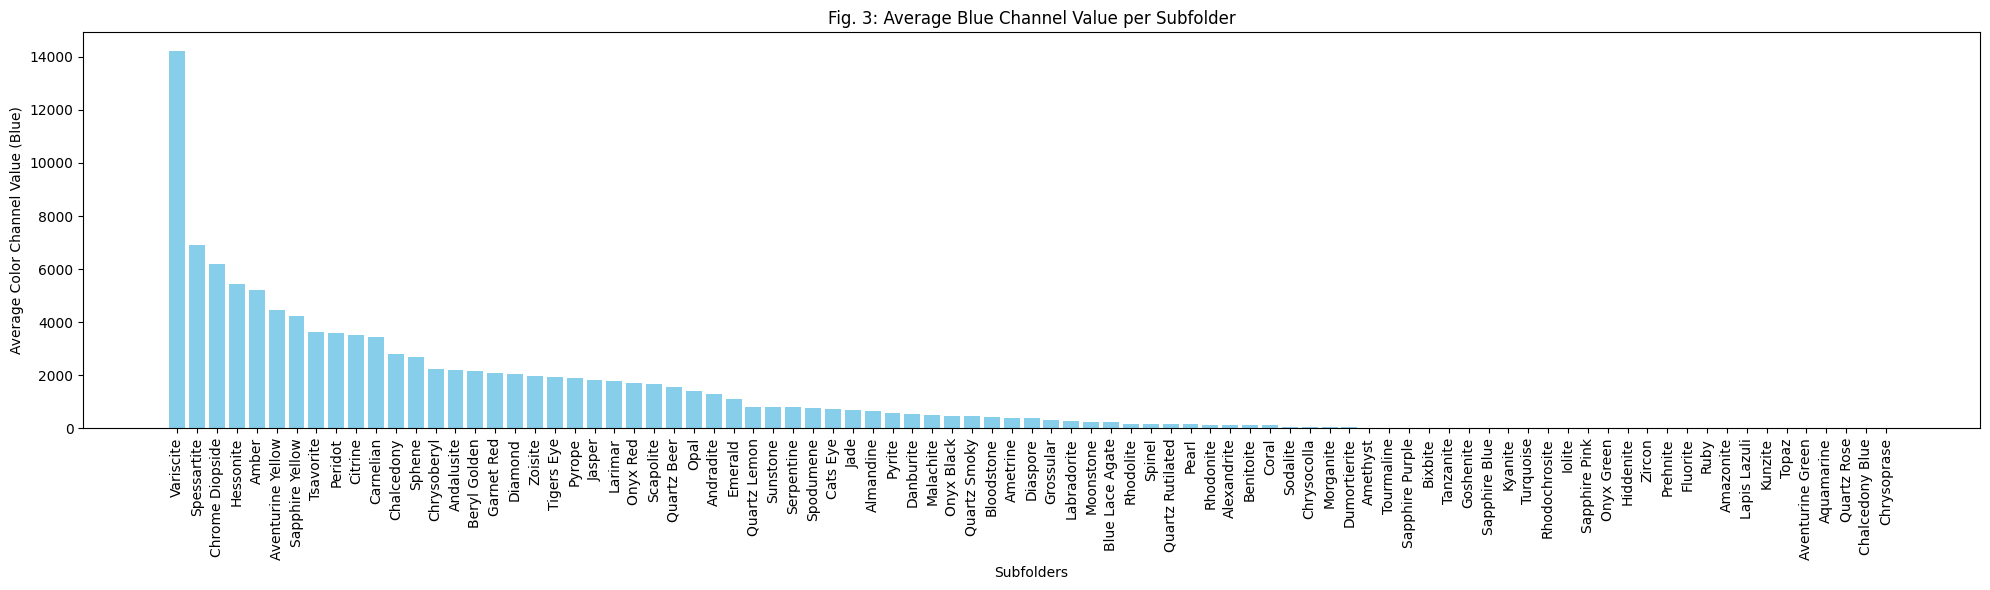

In [68]:
def analyze_subfolder_statistics(directory):
    """Calculates image statistics for each subfolder and displays color channel averages in a histogram.

    Args:
        directory: Path to the directory containing subfolders.
    """

    subfolder_statistics = {}

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            means = []
            std_devs = []
            color_histograms = []

            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path)

                    means.append(np.mean(image))
                    std_devs.append(np.std(image))
                    color_histograms.append(cv2.calcHist([image], [0], None, [256], [0, 256]))  # Blue channel

            subfolder_statistics[subfolder_name] = {
                "avg_mean": np.mean(means),
                "avg_std_dev": np.mean(std_devs),
                "avg_color_histogram": np.mean(color_histograms, axis=0)  # Average color histogram
            }

    # Sort subfolders by average color channel value in decreasing order
    sorted_subfolders = sorted(subfolder_statistics.items(), key=lambda x: x[1]["avg_color_histogram"][0], reverse=True)

    # Display color channel averages in a histogram
    subfolder_names = [item[0] for item in sorted_subfolders]
    avg_color_channels = [item[1]["avg_color_histogram"][0].item() for item in sorted_subfolders]  # Blue channel average

    plt.figure(figsize=(20, 6))  # Adjust figure size as needed
    plt.bar(subfolder_names, avg_color_channels, color='skyblue')
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Channel Value (Blue)")
    plt.title("Fig. 3: Average Blue Channel Value per Subfolder")
    plt.xticks(rotation=90, ha='center')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

directory = 'gemstones-images/train'
analyze_subfolder_statistics(directory)

So I would interpret this to mean that a random example jpg from variscite, spessartite, chrome diopside, hessonite, and amber would have some blue?  Would that be right?

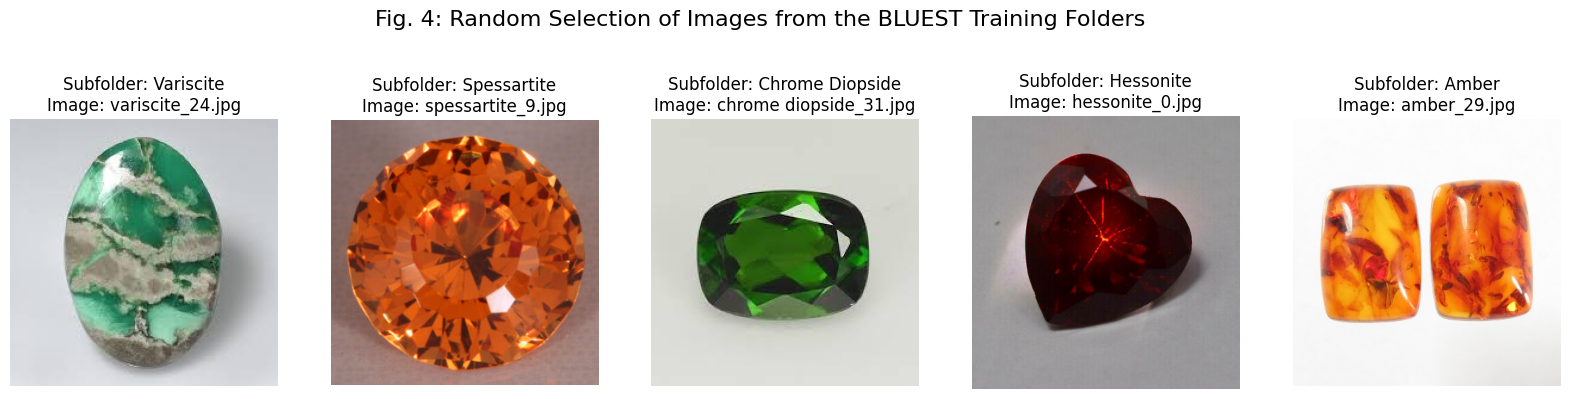

In [69]:
# prompt: show a random example of jpg from variscite, spessartite, chrome diopside, hessonite, and amber subfolders in directorytrain

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

directorytrain = 'gemstones-images/train'
subfolders = ['Variscite', 'Spessartite', 'Chrome Diopside', 'Hessonite', 'Amber']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Fig. 4: Random Selection of Images from the BLUEST Training Folders', fontsize=16)

for i, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(directorytrain, subfolder)
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image)
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Subfolder: {subfolder}\nImage: {random_image}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image", ha='center', va='center')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f"No images in {subfolder}", ha='center', va='center')
        axes[i].axis('off')

plt.show()

That is not really the case with this random selector. Could this be because of the backgrounds of the image?  Or is the average color really blue for these?

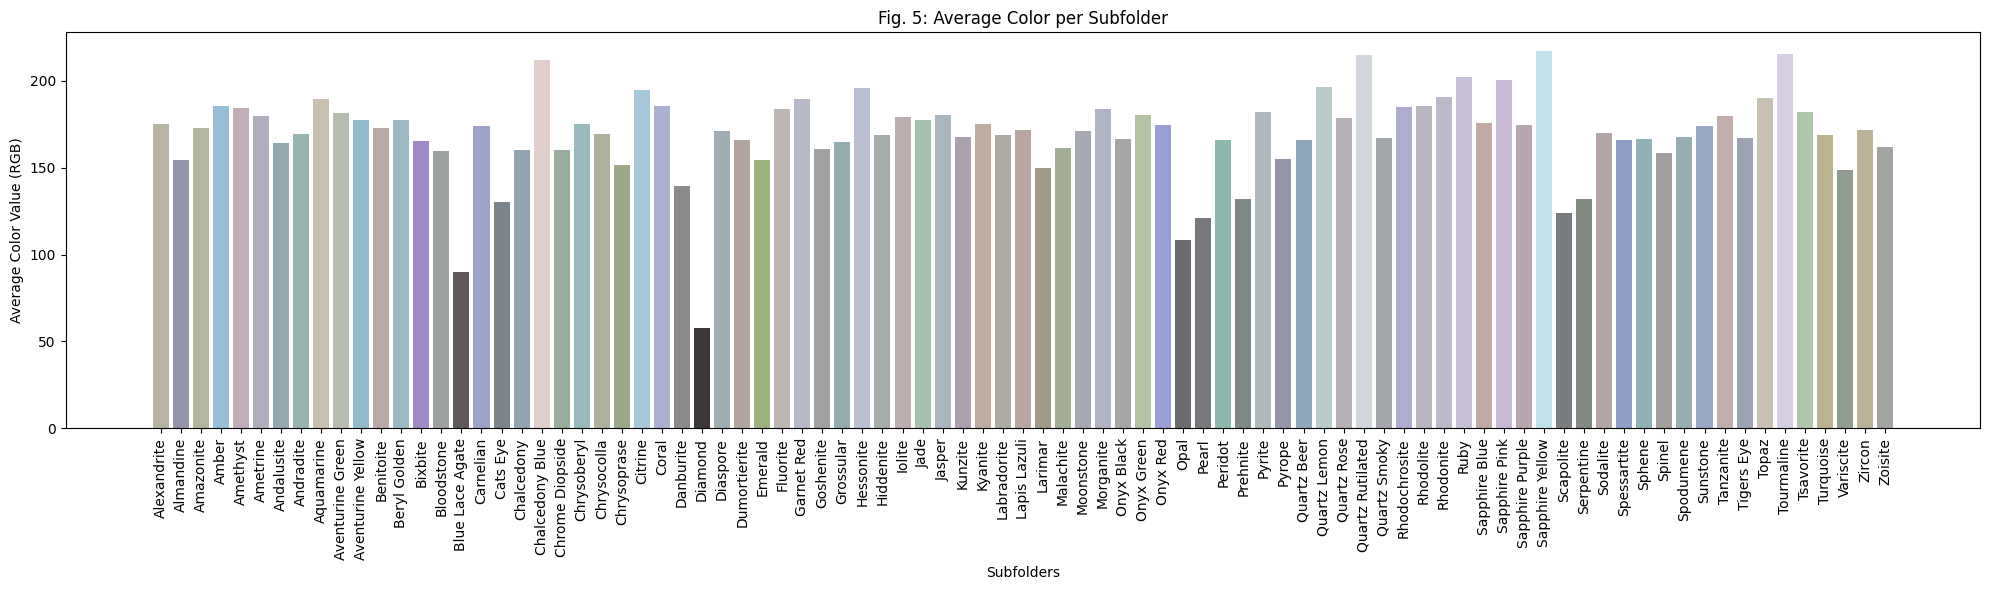

In [70]:
def analyze_subfolder_colors(directory):
    """
    Calculates the average color for all images within each subfolder
    and displays a histogram with the average color RGB value as the bar color.

    Args:
        directory: Path to the directory containing subfolders.
    """

    subfolder_colors = {}

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            average_colors = []

            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path)

                    # Calculate average color for the image
                    average_color = np.mean(image, axis=(0, 1))
                    average_colors.append(average_color)

            # Calculate average color for the subfolder
            subfolder_avg_color = np.mean(average_colors, axis=0) if average_colors else [0, 0, 0]  # Handle empty subfolders
            subfolder_colors[subfolder_name] = subfolder_avg_color

    # Sort subfolders alphabetically
    sorted_subfolders = sorted(subfolder_colors.keys())
    sorted_avg_colors_rgb = [subfolder_colors[subfolder] for subfolder in sorted_subfolders]

    # Convert RGB to hex for bar colors
    bar_colors = [to_hex(color / 255) for color in sorted_avg_colors_rgb]  # Normalize to 0-1 range

    plt.figure(figsize=(20, 6))
    plt.bar(sorted_subfolders, [np.mean(color) for color in sorted_avg_colors_rgb], color=bar_colors)  # Use average color as bar color
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Value (RGB)")
    plt.title("Fig. 5: Average Color per Subfolder")
    plt.xticks(rotation=90, ha='center')
    plt.tight_layout()
    plt.show()

directory = 'gemstones-images/train'
analyze_subfolder_colors(directory)

These look more muted than expected.  I suspected that this could be because the jpg analysis includes the background colors (white, black, gray).  I removed the background from the images and re-ran and did not see a difference in the histogram, so that code is not included.  

I next considered the image size by reviewing the data as a scatter plot.

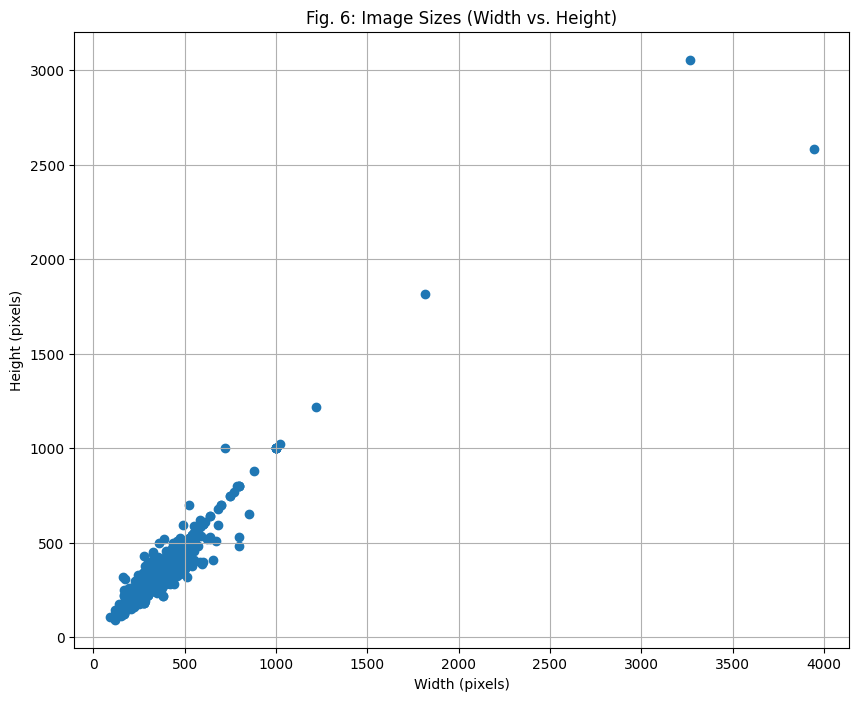

In [71]:
def plot_image_sizes(directory):
  """
  Creates a scatter plot of image sizes (width vs. height) for images in subfolders.

  Args:
      directory: The path to the directory containing subfolders with images.
  """
  widths = []
  heights = []
  labels = []

  for subfolder_name in os.listdir(directory):
    subfolder_path = os.path.join(directory, subfolder_name)
    if os.path.isdir(subfolder_path):
      for filename in os.listdir(subfolder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
          image_path = os.path.join(subfolder_path, filename)
          try:
            image = cv2.imread(image_path)
            height, width, _ = image.shape  # Get height and width
            widths.append(width)
            heights.append(height)
            labels.append(subfolder_name)
          except Exception as e:
            print(f"Error loading image {image_path}: {e}")

  plt.figure(figsize=(10, 8))
  plt.scatter(widths, heights)
  plt.xlabel("Width (pixels)")
  plt.ylabel("Height (pixels)")
  plt.title("Fig. 6: Image Sizes (Width vs. Height)")
  plt.grid(True)
  plt.show()

plot_image_sizes(directorytrain)

In [72]:
def print_large_images(directory, min_width=1500):
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    try:
                        image = cv2.imread(image_path)
                        height, width, _ = image.shape
                        if width > min_width:
                            print(filename)
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

directorytrain = 'gemstones-images/train'
print_large_images(directorytrain)

chrysocolla_1.jpg
chrysocolla_5.jpg
chrysocolla_7.jpg


Some of these larger images might need to be removed if the test data set has mismatches associated with chrysocolla.  

#Questions & Answers

More to be written as supervised learning continues.  